Team members:
- Sophia Gabriela Martinez Albarran A01424430
- Eduardo Botello Casey A01659281
- Marcos Saade Romano A01784220

## Dataset description

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y). It contains 6 integers variables and 11 categorical variables. It has 45211 instances of data, where we will be performing a cleaning and preprocessing before creating the models.

In [27]:
import sklearn 
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
  
# https://archive.ics.uci.edu/dataset/222/bank+marketing  
# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
  
# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 
  
# Drop the column duration because in the page it says it isn't necessary for a predictive model
X = X.drop(columns=['duration'])

In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  campaign     45211 non-null  int64 
 12  pdays        45211 non-null  int64 
 13  previous     45211 non-null  int64 
 14  poutcome     8252 non-null   object
dtypes: int64(6), object(9)
memory usage: 5.2+ MB


In [29]:
X.describe()

,age,balance,day_of_week,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,63.000000,871.000000,275.000000


Filling NANs with the values associated with unknown in the database

In [16]:
X.job = X.job.fillna('unknown')
X.education = X.education.fillna('unknown')
X.poutcome = X.poutcome.fillna('nonexistent')
X.contact = X.contact.fillna('unknown')

In [17]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X.select_dtypes(include=['object']))
X_encoded_df = pd.DataFrame(
    X_encoded.toarray(), 
    columns=encoder.get_feature_names_out(X.select_dtypes(include=['object']).columns)
)


In [18]:
X_numerico = X.select_dtypes(exclude=['object'])
X_final = pd.concat([X_numerico.reset_index(drop=True), X_encoded_df.reset_index(drop=True)], axis=1)

In [19]:
from sklearn.cluster import KMeans
kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_final)
                for k in range(2, 10)]

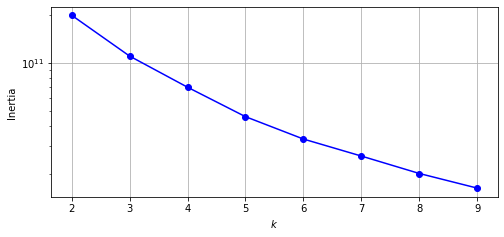

In [20]:
inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(8, 3.5))
plt.plot(range(2, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.yscale('log')
plt.grid()

plt.show()

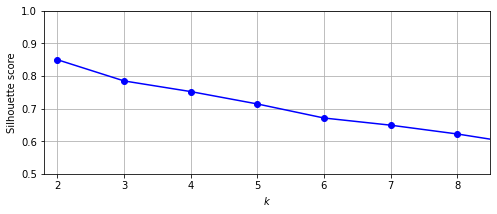

In [23]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_final, model.labels_)
                     for model in kmeans_per_k[0:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.axis([1.8, 8.5, 0.5, 1])

plt.grid()
#save_fig("silhouette_score_vs_k_plot")
plt.show()

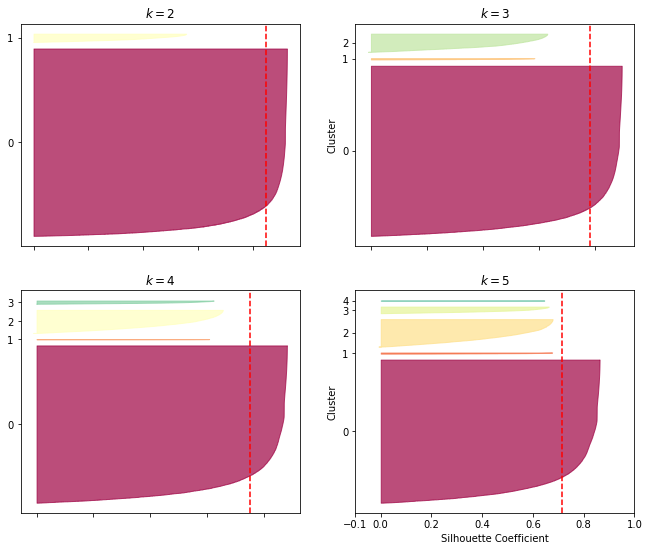

In [31]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 2].labels_
    silhouette_coefficients = silhouette_samples(X_final, y_pred)

    padding = len(X_final) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

# save_fig("silhouette_analysis_plot")
plt.show()

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


y = kmeans_per_k[0].labels_

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Create and train the decision tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)


y_pred = dt_classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)

cm

Decision Tree Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8668
           1       1.00      1.00      1.00       375

    accuracy                           1.00      9043
   macro avg       1.00      1.00      1.00      9043
weighted avg       1.00      1.00      1.00      9043



array([[8668,    0],
       [   0,  375]], dtype=int64)